# Neural Networks L2 Regularization 

This notebook contains the solution for the honor assignment option #2 which has the objective of implementing the L2 objective for the softmax cross entropy loss as shown below: 

$$ Loss = Crossentropy + \alpha \cdot \underset i \sum {w_i}^2 $$

In [1]:
import numpy as np
import matplotlib

Let us first download the necessary data. This data is still from the mnist digit recognizer. 

In [2]:
import sys
sys.path.append("..")
import tqdm_utils
import download_utils

# use the preloaded keras datasets and models
download_utils.link_all_keras_resources()

Using TensorFlow backend.


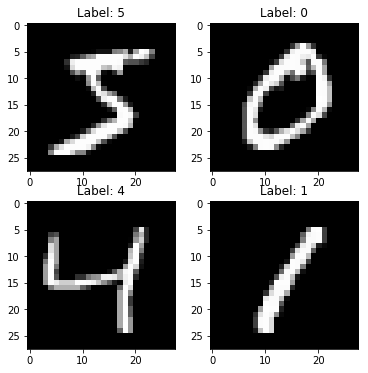

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

Printed below are the shapes of the training and validation sets

In [4]:
print('features train dim:', X_train.shape,
     '\nfeatures test dim:', X_val.shape)

features train dim: (50000, 784) 
features test dim: (10000, 784)


From then on, let us define the needed classes and lambdas to be used for the multilayer perceptron.  

In [5]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

And define the softmax cross entropy loss:

In [6]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

## Gradient modification

Let's now try to derive the gradient of the loss with L2 penalty $\alpha\sum_i{w_i^2}$. We will not try to derive the gradient of the loss wrt to the activation $ a $ as this will result to a very hard derivative to solve. But rather let us notice the fact that the loss with L2 penalty are sums:

$$Loss(a_n,y_n) = a_{correct, n} + log\underset i\sum{e^a_i} + \alpha\sum_{l}^{L}{||\mathbf{w}_l||^2_F}$$

Which we can separate into two terms $L_{xentropy} = a_{correct, n} + log\underset i\sum{e^a_i} $  and $L_{penalty} = \alpha\sum_{l}^{L}{||\mathbf{w}_l||^2_F}$.

Contrary to the usual backpropagtion where we get $\partial L / \partial a$ first then apply chain rule to the previous layers, we retain the derivative of the first term (which we already know) and then for each layer calculate for  $\partial L / \partial w_l$. The stated gradient obtains another term, which is the derivative of the 2nd term wrt to $w_l$. This is equal to:
$$\frac{\partial L_{penalty}}{\partial \mathbf{w}_l} =2\alpha \mathbf{w}_l $$

We now modify the `Dense` class to incorporate the regularization parameter $\alpha$ and the associated gradient.

In [7]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1, alpha = 0):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.alpha = alpha
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, np.transpose(self.weights))
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(np.transpose(input), grad_output) + 2*self.alpha*self.weights
        grad_biases = np.sum(grad_output, axis = 0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

Check if we have the proper dimensions 

In [8]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


## Testing the new gradient

Let's try setting up the network with the new formulation of the the gradients and run it with some data  

In [9]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_f = np.maximum(0, input)
        return relu_f
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad    

For this test, let's try going with $\alpha = 0.001$.

In [10]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    for layer in network:
        input = layer.forward(input)
        activations.append(input)
     
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    #return(layer_inputs)
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # <your code: propagate gradients through the network>
    
    for layer, input in zip(reversed(network), reversed(layer_inputs[:-1])):
        loss_grad = layer.backward(input, loss_grad)
    
        
    return np.mean(loss)

In [11]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_utils.tqdm_notebook_failsafe(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [30]:
network = []
alpha = 0.0001
network.append(Dense(X_train.shape[1],100, alpha = alpha))
network.append(ReLU())
network.append(Dense(100,200, alpha = alpha))
network.append(ReLU())
network.append(Dense(200,10, alpha = alpha))

In [31]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 24
Train accuracy: 0.99976
Val accuracy: 0.9819


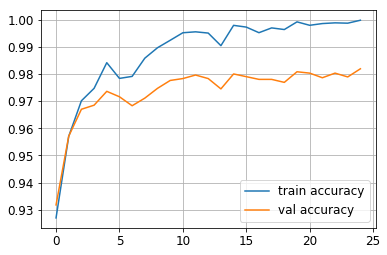

In [32]:
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

## Will regularization help with model complexity?

It is said that applying a regularization term on the loss function helps to avoid overfitting with  model complexity. Let's see if this is true. Let us try fitting a relatively complex model (say neural network with a 5000 units in a hidden layer) and compare the results between a vanilla neural network and one with an L2 penalty/

For these set of experiments, the learning rate will be fixed and the model architecture.

### Trying different L2 regulariztion parameters

In [16]:
n_units = 5000
alphas = np.linspace(0, 0.0001, 5)
epochs = 25

train_alphas = [] 
val_alphas = []

# set seed for numpy rand to ensure that we have the same shuffles for each batching instance
np.random.seed(300)

for alpha in alphas:
        
    network = []
    network.append(Dense(X_train.shape[1], 100, alpha = alpha))
    network.append(ReLU())
    network.append(Dense(100, n_units, alpha = alpha))
    network.append(ReLU())
    network.append(Dense(n_units ,10, alpha = alpha))

    train_log = []
    val_log = []

    for epoch in range(epochs):      

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
            train(network, x_batch, y_batch)


        train_log.append(np.mean(predict(network,X_train)==y_train))
        val_log.append(np.mean(predict(network,X_val)==y_val))
        clear_output()
        print("Epoch",epoch)
        print("alpha =", alpha)
        print("Train accuracy:",train_log[-1])
        print("Val accuracy:",val_log[-1])        
        
    train_alphas.append(train_log)
    val_alphas.append(val_log)
    

Epoch 24
alpha = 0.0001
Train accuracy: 0.9992
Val accuracy: 0.9811


In [24]:
import pickle
pickle.dump(val_alphas, open("val_alphas.pkl", "wb"))

After running the model for both the vanilla neural network ($\alpha$ = 0) and one with L2 penalty with alpha parameters ranging from ($2x10^-5$ to $0.0001$) We can see in the figure below that increasing $\alpha$ helps in improving the validation accuracy despite the very complex model that was defined.

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


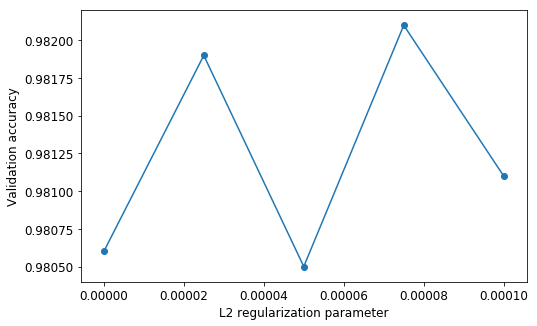

In [27]:
import matplotlib
import matplotlib.pyplot as plt

val_arr = np.array(val_alphas)

matplotlib.rcParams.update({'font.size' : 12})

fig, ax = plt.subplots(1,figsize = (8,5))
ax.plot(alphas, val_arr[:,-1],)
ax.scatter(alphas, val_arr[:,-1])
ax.set_ylabel('Validation accuracy')
ax.set_xlabel('L2 regularization parameter')
plt.legend(loc = 'best')

plt.show()